In [1]:
!pip install psycopg2-binary
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install sklearn

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

conn = psycopg2.connect(
    host="postgres",
    database="metrics",
    user="postgres",
    password="metrics_pass")
print("Connected to postgres")

#getting all itens
cur = conn.cursor()


Connected to postgres


In [2]:
cluster = "main-cluster"
namespace = "social-network"
deployment_name = "user-service"

In [3]:
#get the node metrics
cur.execute("SELECT * from public.deployments where name = '" + deployment_name + "' and namespace = '" + namespace + "' and cluster = '" + cluster + "'")
deployments = cur.fetchall()

#convert the deploy to dict
deploys = []
allmetrics = []
for deploy in deployments:
    deployValue = {
        "id": deploy[0],
        "nome": deploy[1],
        "namespace": deploy[2],
        "cluster": deploy[3],
        "replicas": deploy[4],
        "minCpu": deploy[5],
        "maxCpu": deploy[6],
        "mimMemory": deploy[7],
        "maxMemory": deploy[8]
    }
    #get pods
    cur.execute("SELECT * from public.pods where deployment_id =" + str(deployValue["id"]))
    podsDb = cur.fetchall()

    #convert pods to dict
    pods = []
    podsIds = []
    for pod in podsDb:
        podValue = {
            "id": pod[0],
            "deploymentId": pod[1],
            "name": pod[2],
            "nodeId": pod[3]
        }
        pods.append(podValue)
        podsIds.append(podValue["id"])
    
    #getting pods metrics
    cur.execute('SELECT * from public.pods_metrics where pod_id in ' + str(podsIds).replace("[", "(").replace("]", ")"))
    podsMetricsDb = cur.fetchall()
    #convert pods metricas to dict
    for podMetrics in podsMetricsDb:
        podMetricsValue = {
            "id": podMetrics[0],
            "pod_id": podMetrics[1],
            "coleta_raw": podMetrics[2],
            "coleta": podMetrics[2].strftime("%m/%d/%Y, %H:%M"),
            "coleta_hora": podMetrics[2].strftime("%H"),
            "cpu": podMetrics[3],
            "men": podMetrics[4]
        }
        allmetrics.append(podMetricsValue)
        
    deployValue["pods"] = pods
    deploys.append(deployValue)

Cpu usage by hour


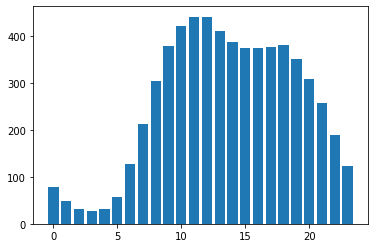

In [4]:
print("Cpu usage by hour")
cpus = []
for i in range(24):
    cpus.append([])
    
for metrica in allmetrics:
    cpus[int(metrica["coleta_hora"])].append(metrica["cpu"])
    
x=range(24)
y=[]
for i in range(24):
    y.append(sum(cpus[i]) / len(cpus[i]))
    
plt.bar(x,y)
plt.show()



Cpu usage histogram


Text(0, 0.5, 'Cpu Power')

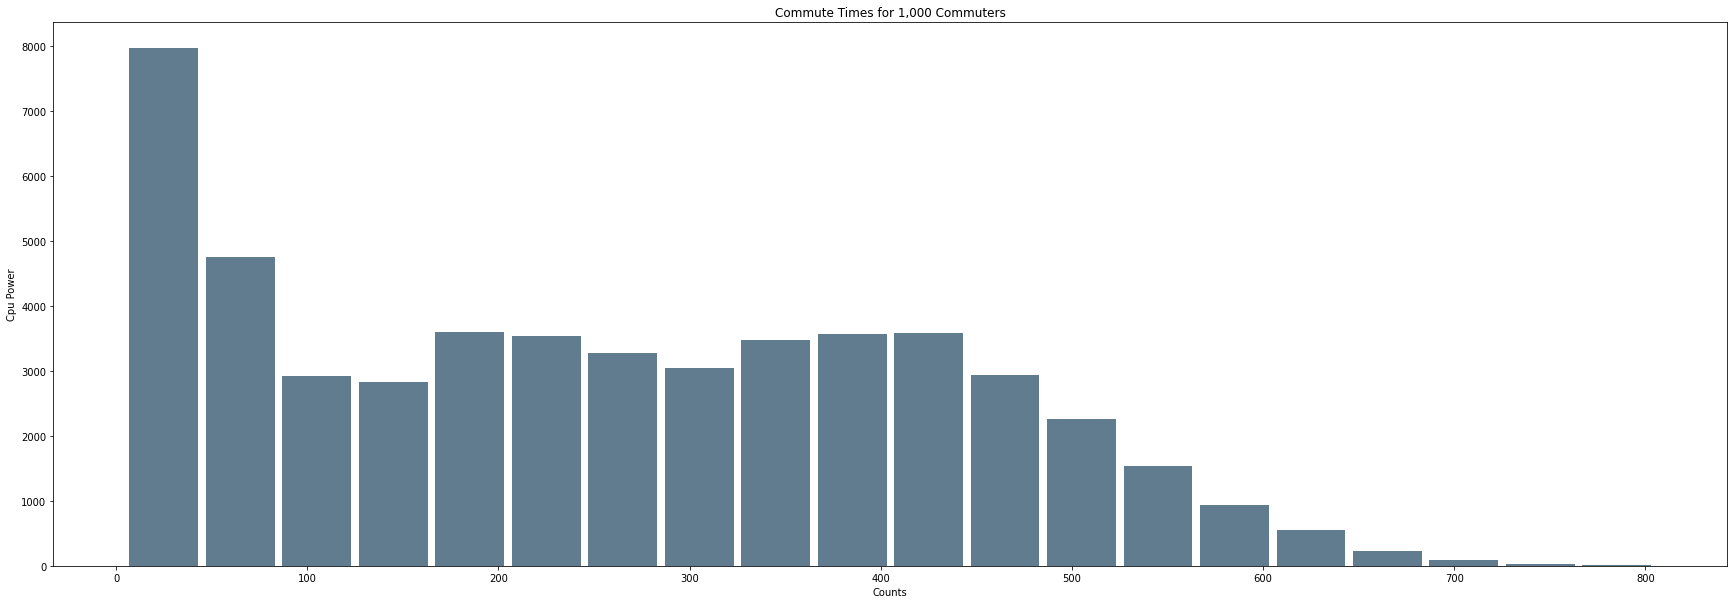

In [5]:
import math
print("Cpu usage histogram")
cpu_usages = []

for metrica in allmetrics:
    cpu_usages.append(metrica["cpu"])

# the histogram of the data


# Generate data on commute times.
commutes = pd.Series(cpu_usages)

commutes.plot.hist(grid=False, bins=20, rwidth=0.9,
                   color='#607c8e', figsize=(30, 10))
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Cpu Power')


In [6]:
print("Get high usage cpu pods")
cpusDic = {}

    
for metrica in allmetrics:
    if(metrica["coleta"] in cpusDic):
        cpusDic[metrica["coleta"]]["cpus"].append(metrica["cpu"])
        cpusDic[metrica["coleta"]]["pods"] += 1
    else:
        cpusDic[metrica["coleta"]] = {
            "cpus" : [metrica["cpu"]],
            "pods": 1,
            "hora": metrica["coleta_hora"],
            "coleta": metrica["coleta"]
        }
        
cpus = []
for i in range(24):
    cpus.append([])

offenders = []
print("Pod offenders")
for key in cpusDic:
    if(len(cpusDic[key]["cpus"]) > 20):
        print(cpusDic[key])
    for cpu in cpusDic[key]["cpus"]:
        if(cpu >= 2000):
            offenders.append(cpusDic[key])
            break
print("Cpu offenders")            
for offender in offenders:    
    print(offender)
    

Get high usage cpu pods
Pod offenders
Cpu offenders


Deviation: 
Mean: 255.18729581156953


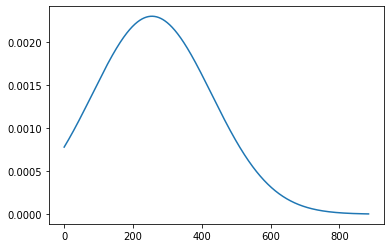

In [7]:
import statistics
import numpy as np
from scipy.stats import norm

cpuMetrics = [] 
for metric in allmetrics:
    cpuMetrics.append(metric["cpu"])
avg = sum(cpuMetrics)/len(cpuMetrics)
maxcpu = max(cpuMetrics)

print("Deviation: " + str())
print("Mean: " + str(avg))

x_axis = np.arange(0, maxcpu*1.1, 1)

plt.plot(x_axis, norm.pdf(x_axis, avg, statistics.stdev(cpuMetrics)))
plt.show()

In [8]:
print("Calculate cpu oever propabolity")
from scipy.stats import norm
prob = 0
cpu = 0
while prob < 0.8:
    cpu += 100 
    prob = norm(avg, statistics.stdev(cpuMetrics)).cdf(cpu)
print("cpu:" + str(cpu))
print("prop:" + str(prob))
cpu_recomendation = cpu
print("cpu:" + str(cpu*100/80))
print("prop:" + str(prob))

Calculate cpu oever propabolity
cpu:500
prop:0.9209057363464765
cpu:625.0
prop:0.9209057363464765


In [9]:
print("Deploy calculations")

Deploy calculations


Mean deploy Cpu usage by hour


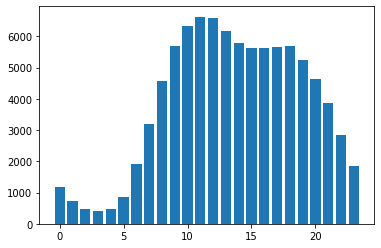

In [10]:
print("Mean deploy Cpu usage by hour")
cpusDic = {}

    
for metrica in allmetrics:
    if(metrica["coleta"] in cpusDic):
        cpusDic[metrica["coleta"]]["cpus"].append(metrica["cpu"])
        cpusDic[metrica["coleta"]]["pods"] += 1
    else:
        cpusDic[metrica["coleta"]] = {
            "cpus" : [metrica["cpu"]],
            "pods": 1,
            "hora": metrica["coleta_hora"]
        }
        
cpus = []
for i in range(24):
    cpus.append([])
    
for key in cpusDic:
    cpus[int(cpusDic[key]["hora"])].append(sum(cpusDic[key]["cpus"]))
    
x=range(24)
y=[]
for i in range(24):
    y.append(sum(cpus[i]) / len(cpus[i]))
    
plt.bar(x,y)
plt.show()

Mean deploy pods by hour


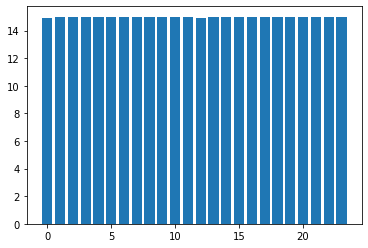

In [11]:
print("Mean deploy pods by hour")
cpusDic = {}

    
for metrica in allmetrics:
    if(metrica["coleta"] in cpusDic):
        cpusDic[metrica["coleta"]]["cpus"].append(metrica["cpu"])
        cpusDic[metrica["coleta"]]["pods"] += 1
    else:
        cpusDic[metrica["coleta"]] = {
            "cpus" : [metrica["cpu"]],
            "pods": 1,
            "hora": metrica["coleta_hora"]
        }
        
cpus = []
for i in range(24):
    cpus.append([])
    
for key in cpusDic:
    cpus[int(cpusDic[key]["hora"])].append(len(cpusDic[key]["cpus"]))
    
x=range(24)
y=[]
for i in range(24):
    y.append(sum(cpus[i]) / len(cpus[i]))
    
plt.bar(x,y)
plt.show()

In [12]:
cpusDic = {}
    
    
for metrica in allmetrics:
    if(metrica["coleta"] in cpusDic):
        cpusDic[metrica["coleta"]]["cpus"].append(metrica["cpu"])
        cpusDic[metrica["coleta"]]["pods"] += 1
    else:
        cpusDic[metrica["coleta"]] = {
            "cpus" : [metrica["cpu"]],
            "pods": 1,
            "hora": metrica["coleta_hora"]
        }
        
cpus = []
for i in range(24):
    cpus.append([])

cpu_usages = []
for key in cpusDic:
    cpu_usages.append(sum(cpusDic[key]["cpus"]))
maxcpu = max(cpu_usages)

deploy Cpu usage histogram


Text(0, 0.5, 'Cpu Power')

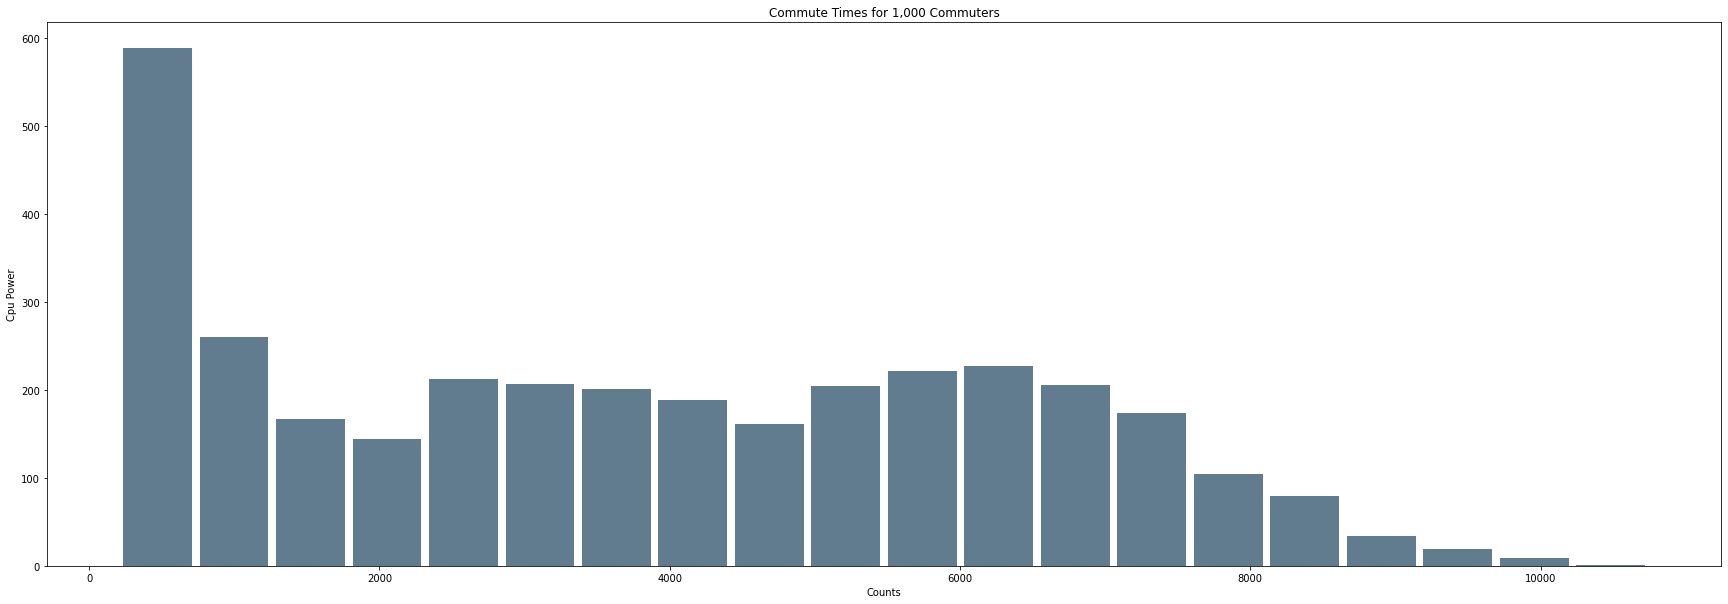

In [13]:
import math

print("deploy Cpu usage histogram")

# the histogram of the data
import pandas as pd

# Generate data on commute times.
commutes = pd.Series(cpu_usages)

commutes.plot.hist(grid=False, bins=20, rwidth=0.9,
                   color='#607c8e', figsize=(30, 10))
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Cpu Power')


Deviation: 
Mean: 3824.2184110231606


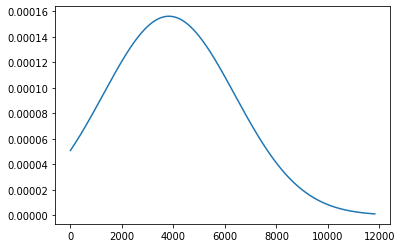

In [14]:
import statistics
import numpy as np
from scipy.stats import norm


avg = sum(cpu_usages)/len(cpu_usages)

print("Deviation: " + str())
print("Mean: " + str(avg))

x_axis = np.arange(0, maxcpu*1.1, 1)

plt.plot(x_axis, norm.pdf(x_axis, avg, statistics.stdev(cpu_usages)))
plt.show()

In [15]:
print("Calculate cpu over propabolity by deploy")
from scipy.stats import norm
prob = 0
cpu = 0
while prob < 0.8:
    cpu += 100 
    prob = norm(avg, statistics.stdev(cpu_usages)).cdf(cpu)
print("cpu:" + str(cpu))
deploy_cpu_recomendation = cpu
print("prop:" + str(prob))

Calculate cpu over propabolity by deploy
cpu:6000
prop:0.8028187317433964


In [16]:
print("Make the speedup correction")

Make the speedup correction


1
final
[0, 500, 2000, 10000]
[0.0, 0.9999999999999999, 3.07321274532082, 7.822395079463035]


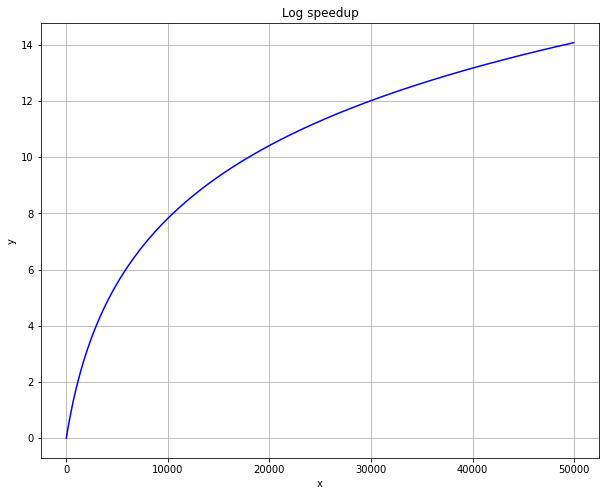

In [46]:
from scipy.interpolate import lagrange
x_old = []
y = []

jump = 10
divid = 0
multiplier = 1

initpoint = cpu_recomendation
grow = 1
mainpoint = initpoint*grow

bigjump = 1

def f(x):
    y = []
    for i in x:
        point = (jump + i*grow)/(jump+mainpoint)*10
        try:
            value = (math.log(point*bigjump, 10) - divid)*multiplier
        except:
            print(i)
            print(point)
            print(bigjump)
            print(jump)
            print(mainpoint)
            raise "Ruim"
        y.append(value)
    return y


interk = 0
finded = False
maxp = 1000
while(interk< maxp and not finded):
    #reset loop
    interj = 0
    
    grow = 1
    mainpoint = initpoint*grow
   
    interk +=1
    print(interk)
    bigjump += 100


    while(interj < maxp and not finded):
        #inter
        interj +=1
        grow += 10
        mainpoint = initpoint*grow
        
        #reset loop
        interi = 0        
        jump = 10
        while(interi < maxp and not finded):
            #inter
            interi += 1
            jump += 50
            
            #reset
            divid = 0
            multiplier = 1
            
            #define param
            divid = f([0])[0]
            if(f([initpoint])[0] ==0):
                continue
            multiplier = 1/f([initpoint])[0]
            
            #test
            if(f([initpoint*2])[0] > 1.8 and f([initpoint*2])[0] < 1.85 and f([initpoint*10])[0] > 5.5 and f([initpoint*10])[0] < 5.6):
                finded = True
print("final")
print([0, initpoint, 2000, 10000])
print(f([0, initpoint, 2000, 10000]))

fig = plt.figure(figsize = (10,8))
x_new = []
for i in range(1000):
    x_new.append(i*50)  
plt.plot(x_new, f(x_new), 'b' )
plt.title('Log speedup')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [48]:
pods = 7
mul_target = (deploy_cpu_recomendation/pods)/cpu_recomendation
actual_div = 0
cpu_target = 0
while(actual_div < mul_target):
    cpu_target += 5
    actual_div = f([cpu_target])[0]/f([cpu_recomendation])[0]
print("Target " + str(cpu_target))



Target 940
